# 1. Data Collection and Preprocessing 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 1 1 0 2 1 1 0 0 0 0 1 2 0 1 1 1 0 0 1 0 0 1 2 1 0 1 1 1]


In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    

[[[177. 176. 184.]
  [183. 182. 190.]
  [190. 189. 197.]
  ...
  [167. 164. 173.]
  [166. 163. 172.]
  [155. 152. 161.]]

 [[182. 181. 189.]
  [184. 183. 191.]
  [185. 184. 192.]
  ...
  [159. 156. 165.]
  [157. 154. 163.]
  [146. 143. 152.]]

 [[177. 176. 184.]
  [175. 174. 182.]
  [172. 171. 179.]
  ...
  [158. 155. 164.]
  [157. 154. 163.]
  [149. 146. 155.]]

 ...

 [[196. 193. 200.]
  [195. 192. 199.]
  [195. 192. 199.]
  ...
  [145. 142. 149.]
  [148. 145. 152.]
  [150. 147. 154.]]

 [[198. 195. 202.]
  [193. 190. 197.]
  [190. 187. 194.]
  ...
  [148. 145. 152.]
  [146. 143. 150.]
  [142. 139. 146.]]

 [[198. 195. 202.]
  [190. 187. 194.]
  [184. 181. 188.]
  ...
  [152. 149. 156.]
  [149. 146. 153.]
  [140. 137. 144.]]]


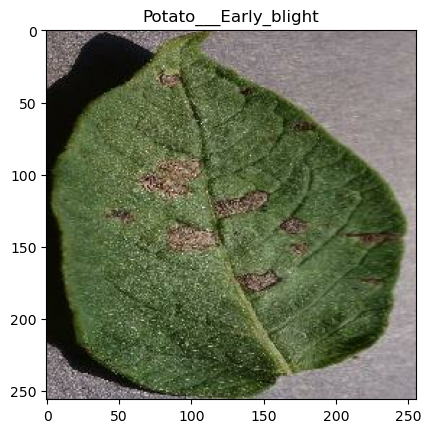

In [8]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    # print(image_batch[0].numpy())
    

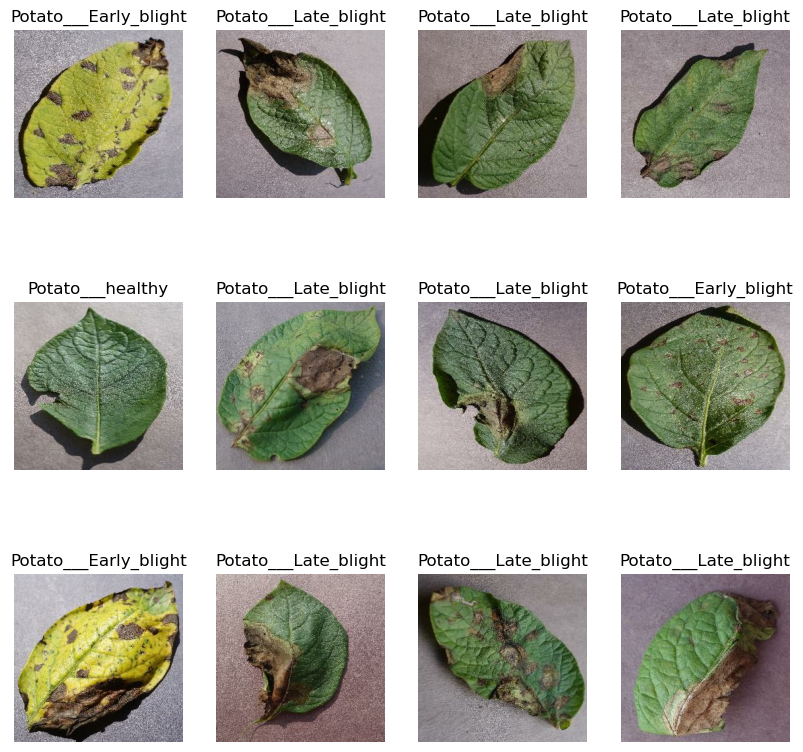

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12): 
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        # print(image_batch[0].numpy())

In [10]:
len(dataset)

68

In [11]:
#  80% train 
# 10% validation after epochs for find accuracy 
# test 10%

In [12]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds=dataset.take(54)
len(train_ds)

54

In [14]:
test_ds=dataset.skip(54)

In [15]:
len(test_ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)

    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
    


In [20]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(test_ds)

8

In [23]:
# cache() use this method for save image once in stroage 
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
# resize_and_rescale=tf.keras.Sequential([
#     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
#     layers.experimental.preprocessing.Rescaling(1.0/255)
# ])
# Define resizing and rescaling layer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
resize_and_rescale=Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])
# resize_and_rescale = tf.keras.Sequential([
#     layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize the image
#     layers.Rescaling(1.0 / 255)  # Rescale pixel values
# ])

In [25]:
data_argumentation=tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

# 2. Model Building  

In [26]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

In [27]:


model = models.Sequential([
    resize_and_rescale,
    data_argumentation,
    layers.Conv2D(32, (2,2), activation='relu', input_shape=input),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 255, 255, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,411 (1.06 MB)

 Trainable params: 277,411 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
EPOCHS=40
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4921 - loss: 0.9379 - val_accuracy: 0.6875 - val_loss: 0.7375
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 965ms/step - accuracy: 0.7439 - loss: 0.6211 - val_accuracy: 0.7135 - val_loss: 0.7268
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 893ms/step - accuracy: 0.8431 - loss: 0.4084 - val_accuracy: 0.8177 - val_loss: 0.4306
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 897ms/step - accuracy: 0.8449 - loss: 0.3408 - val_accuracy: 0.8490 - val_loss: 0.3465
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8756 - loss: 0.2722 - val_accuracy: 0.8073 - val_loss: 0.4737
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 900ms/step - accuracy: 0.9114 - loss: 0.2326 - val_accuracy: 0.9219 - val_loss: 0.2129
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 907ms/step - accuracy: 0.9269 - loss: 0.2124 - val_accuracy: 0.9167 - val_loss: 0.2624
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 897ms/step - accuracy: 0.9330 - loss: 0.1789 - val_accuracy: 

In [31]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.9695 - loss: 0.1322


In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [35]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

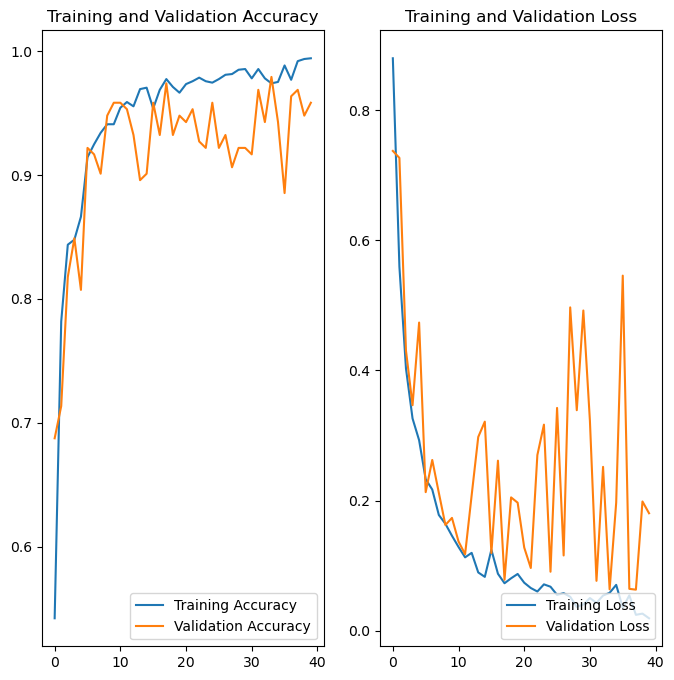

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')


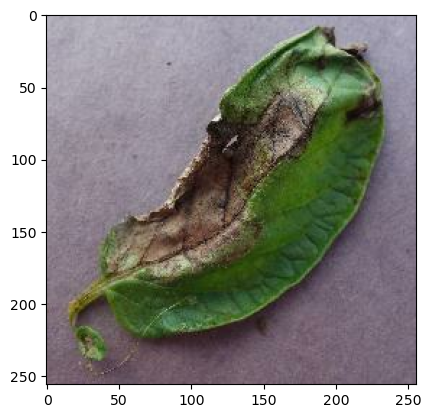

In [37]:
for image_batch,label_batch in test_ds.take(1):
    plt.imshow((image_batch[0].numpy().astype('uint8')))

First image to predict
actual label : Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
Potato___Late_blight


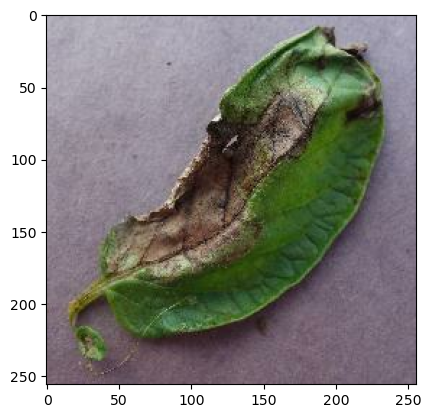

In [38]:
import numpy as np
for images_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    print('First image to predict')
    plt.imshow(first_image)
    print("actual label :",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


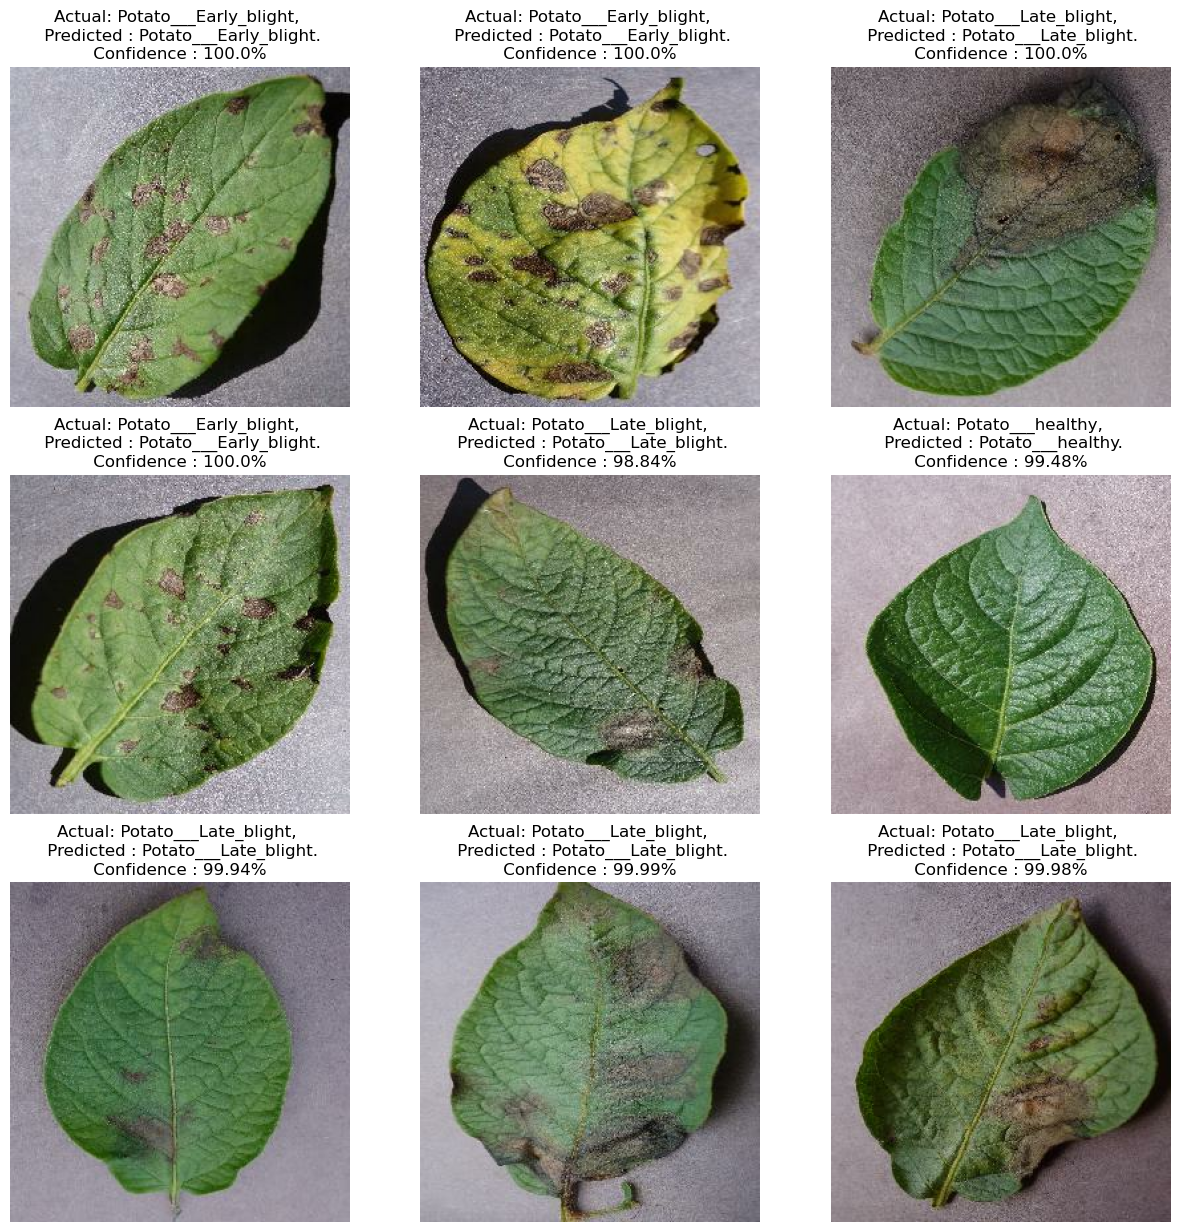

In [39]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)#Create a batch
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i].numpy()]
        plt.title(f"Actual: {actual_class}, \n Predicted : {predicted_class}.\n Confidence : {confidence}% ")
        plt.axis('off')
plt.show()


In [40]:
# def predict(model, img):
#     # Convert the image to an array and preprocess it
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = tf.expand_dims(img_array, 0)  # Expand dimensions to match the batch shape
    
#     # Predict the class probabilities
#     prediction = model.predict(img_array)
    
#     # Get the predicted class and confidence
#     predicted_class = class_names[np.argmax(prediction[0])]
#     confidence = round(100 * (np.max(prediction[0])), 2)
#     return predicted_class, confidence

# # Visualize predictions
# plt.figure(figsize=(15, 15))
# for images, labels in test_ds.take(1):  # Take one batch from the test dataset
#     for i in range(9):  # Display predictions for 9 images
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
        
#         # Predict for the current image
#         predicted_class, confidence = predict(model, images[i].numpy())
#         actual_class = class_names[labels[i].numpy()]

#         # Display the result
#         plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
#         plt.axis("off")
# plt.show()


In [41]:
model_version = 2
model.save(f"C:/Users/HP/Documents/DL/model/{model_version}.keras")  # Save in Keras format


In [42]:
from tensorflow.keras.models import load_model

# Load the model that was saved in .keras format
model = load_model('C:/Users/HP/Documents/DL/model/1.keras')


In [43]:
# # Specify the folder where you want to save the model
# save_dir = 'C:/Users/HP/Documents/DL/model/1_saved_model'

# # Save the model in the TensorFlow SavedModel format
# model.save(save_dir, save_format='tf')
